# CSE 158: Assignment 2

## Part 1: Introduction

## Part 2: Exploratory Data Analysis

In [1]:
!pip install tf-keras transformers datasets accelerate sentencepiece

  Using cached protobuf-6.33.1-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 19.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 18.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 MB 19.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 19.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 16.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.3 MB/s eta 0:00:00
  

In [2]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score

In [3]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l, {"true": True, "false": False})

In [4]:
# Takes about 1-2 minutes to run
data = parse('goodreads_reviews_spoiler.json.gz')
data = list(data)

In [5]:
for i in data:
    datum = dict(i)
    break
for i in datum:
    print(i)

user_id
timestamp
review_sentences
rating
has_spoiler
book_id
review_id


In [6]:
datum['review_sentences']

[[0, 'This is a special book.'],
 [0,
  'It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind.'],
 [0,
  'This is what I love about good science fiction - it pushes your thinking about where things can go.'],
 [0,
  "It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read."],
 [0,
  'For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc.'],
 [0, 'It is a book about science, and aliens.'],
 [0,
  'The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell.'],
 [1,
  'Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though.'],
 [1,
  'But what would happen if our SETI stations received a message - if we found someone wa

In [7]:
df = pd.DataFrame(data)
df.head()

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id
0,8842281e1d1347389f2ab93d60773d4d,2017-08-30,"[[0, This is a special book.], [0, It started ...",5,True,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb
1,8842281e1d1347389f2ab93d60773d4d,2017-03-22,"[[0, Recommended by Don Katz.], [0, Avail for ...",3,False,16981,a5d2c3628987712d0e05c4f90798eb67
2,8842281e1d1347389f2ab93d60773d4d,2017-03-20,"[[0, A fun, fast paced science fiction thrille...",3,True,28684704,2ede853b14dc4583f96cf5d120af636f
3,8842281e1d1347389f2ab93d60773d4d,2016-11-09,"[[0, Recommended reading to understand what is...",0,False,27161156,ced5675e55cd9d38a524743f5c40996e
4,8842281e1d1347389f2ab93d60773d4d,2016-04-25,"[[0, I really enjoyed this book, and there is ...",4,True,25884323,332732725863131279a8e345b63ac33e


In [8]:
# Proportion of reviews with spoilers
df['has_spoiler'].mean()

0.06503980673902585

In [9]:
df_subset = df.sample(n=100000, random_state=42)
df_subset.head()

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id
147051,818a07d4b1a085d65a3851c9f68f148d,2017-02-28,"[[0, Not sure I'm going to write a full review...",4,False,28587986,e514962749c07da42f1390899687b4ad
1322675,eac49beafd4485d9c564dc8fab576fb8,2014-10-29,"[[0, Hooray this book is finally out!], [0, An...",4,False,15844362,138145607be0564b1695e17590348035
1221889,c6f39599f1c5d67d491a86fa6bafb816,2013-08-31,"[[0, I think I'm losing interest in NA.], [0, ...",0,False,17571742,30b720179cdf157b904d06f038dfc8a2
1008531,900c1edf2ede90f385872938ce6f16c9,2014-07-04,"[[0, This book features Michael, the man who d...",4,True,22370569,bf1dc58672a2e92a66ae117100356566
859048,8dab3f118616eb3f550a927f35533905,2015-02-09,"[[0, As with the first book in the Kitty Norvi...",5,False,14460,23cee20df1f02784af03f3af30ae21e9


In [10]:
df_subset['has_spoiler'].mean()

0.06547

The data appears to be very imbalanced--only about 6.5% of all reviews in this dataset seem to contain some sort of spoilers. This makes using other metrics like recall, precision, and F1-score much more meaningful.

Are people more likely to give spoilers in their reviews if they rate it high?

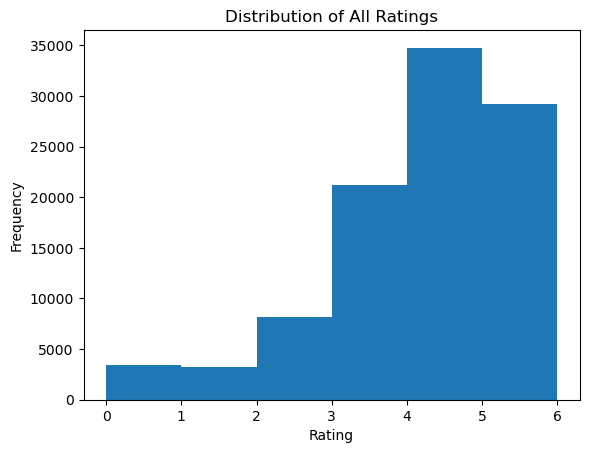

In [11]:
# Distribution of all ratings
all_ratings = df_subset['rating']
plt.hist(all_ratings, bins=np.arange(0, 7))
plt.title('Distribution of All Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Some basic statistical information for all ratings
print("All Ratings Statistics:")
print(f"Mean: {np.mean(all_ratings)}")
print(f"Median: {np.median(all_ratings)}")
print(f"Standard Deviation: {np.std(all_ratings)}")

All Ratings Statistics:
Mean: 3.68258
Median: 4.0
Standard Deviation: 1.2538598580384426


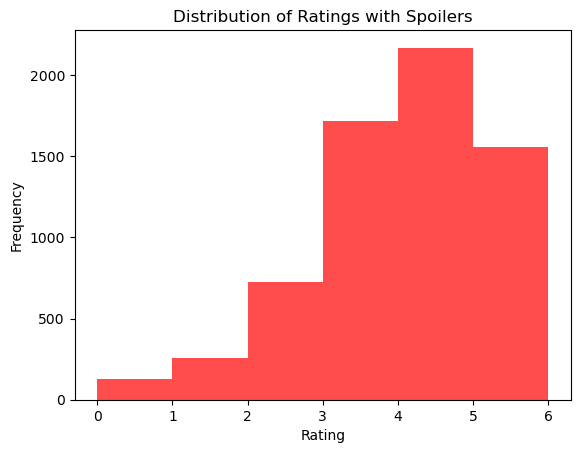

In [13]:
# Distribution of ratings with spoilers
spoiler_ratings = df_subset[df_subset['has_spoiler'] == True]['rating']
plt.hist(spoiler_ratings, bins=np.arange(0, 7), color='red', alpha=0.7)
plt.title('Distribution of Ratings with Spoilers')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Some basic statistical information for ratings with spoilers
print("Spoiler Ratings Statistics:")
print(f"Mean: {np.mean(spoiler_ratings)}")
print(f"Median: {np.median(spoiler_ratings)}")
print(f"Standard Deviation: {np.std(spoiler_ratings)}")

Spoiler Ratings Statistics:
Mean: 3.5610203146479305
Median: 4.0
Standard Deviation: 1.1858318158613597


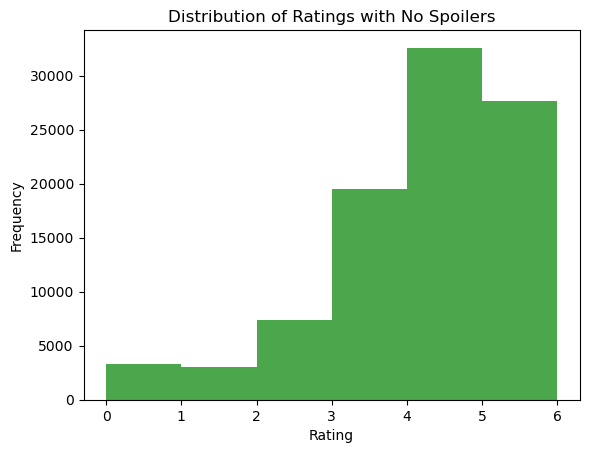

In [15]:
# Distribution of ratings with no spoilers
no_spoiler_ratings = df_subset[df_subset['has_spoiler'] == False]['rating']
plt.hist(no_spoiler_ratings, bins=np.arange(0, 7), color='green', alpha=0.7)
plt.title('Distribution of Ratings with No Spoilers')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Some basic statistical information for ratings with no spoilers
print("Non-Spoiler Ratings Statistics:")
print(f"Mean: {np.mean(no_spoiler_ratings)}")
print(f"Median: {np.median(no_spoiler_ratings)}")
print(f"Standard Deviation: {np.std(no_spoiler_ratings)}")

Non-Spoiler Ratings Statistics:
Mean: 3.69109605898152
Median: 4.0
Standard Deviation: 1.2580476648388919


Maybe if a book was not very enjoyable, people would spoil the plot so that others can save time/money. If a book was actually enjoyable, people would let people experience it for themselves.

Next step: maybe we can engineer a feature that is the proportion of sentences that are rated a spoiler?

## Part 3: Modeling

In [21]:
## ARCHIVED BLOCK
# Verify that each review is a list of lists of length 2 (first entry is whether it's a spoiler, second entry is the sentence)
for i in X_train[:1]:
    print(i)

[[0, 'This review is for the audio version narrated by Lenny Henry.'], [0, 'If I had read this first, I would have been oh so disappointed by American Gods.'], [0, "No, this isn't a book that will change your life."], [0, "It won't even start you thinking about changing your life."], [0, "It's a fun way to spend a few hours, and there's nothing at all wrong with that!"], [0, 'By the way, I would recommend the audio Lenny Henry version--his narration is spot on.']]


In [19]:
df_subset.shape

(100000, 7)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_subset['review_sentences'], df_subset['has_spoiler'], test_size=0.2, random_state=42)

In [20]:
def make_corpus(X):
    corpus_set = []
    for sentences in X:
        corpus = [sentence[1] for sentence in sentences]
        corpus_set.append(" ".join(corpus))
    return corpus_set

In [22]:
X_train = make_corpus(X_train)
X_test = make_corpus(X_test)
y_train = list(y_train.apply(int))
y_test = list(y_test.apply(int))

In [23]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=200))
])

In [24]:
param_grid = {
    'clf__C': [0.1, 1, 3],
    'clf__penalty': ['l2'],
    'clf__class_weight': [None, 'balanced'],
}

In [25]:
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1'
)

grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=10000,
                                                        ngram_range=(1, 2))),
                                       ('clf',
                                        LogisticRegression(max_iter=200))]),
             param_grid={'clf__C': [0.1, 1, 3],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__penalty': ['l2']},
             scoring='f1')

In [26]:
baseline_predictions = grid.predict(X_test)
baseline_predictions

array([1, 0, 0, ..., 1, 0, 0])

In [27]:
# Evaluate baseline model
print(f'The F1-score for the best baseline logistic regression model is: {grid.best_score_}')
print(classification_report(y_test, baseline_predictions))
print(confusion_matrix(y_test, baseline_predictions))

The F1-score for the best baseline logistic regression model is: 0.291032347432367
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     18696
           1       0.19      0.65      0.30      1304

    accuracy                           0.80     20000
   macro avg       0.58      0.73      0.59     20000
weighted avg       0.92      0.80      0.84     20000

[[15149  3547]
 [  459   845]]


In [ ]:
# Imports for DistilBERT model
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
# Create Hugging Face datasets
train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
test_dataset = Dataset.from_dict({'text': X_test, 'label': y_test})

In [ ]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [ ]:
# Define tokenize function
def preprocess(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256  # good length for reviews
    )

In [ ]:
# Apply tokenization to both train/test datasets
train_dataset = train_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
# Remove raw text
train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])

In [ ]:
# Set format to PyTorch
train_dataset.set_format("torch")
test_dataset.set_format("torch")

In [ ]:
# Get DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Make training arguments
training_args = TrainingArguments(
    output_dir="distilbert-output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True
)

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
def compute_metrics(pred):
    predictions = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average='binary'
    )
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [ ]:
# Train with Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

NameError: name 'training_args' is not defined

In [ ]:
# Begin training (may take a while)
trainer.train()

In [ ]:
# Evaluate DistilBERT model
trainer.evaluate()

NameError: name 'trainer' is not defined

In [ ]:
# Sample review
import torch

text = "The ending where he dies made me cry."

tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Move tokens to the same device as the model
tokens = {k: v.to(model.device) for k, v in tokens.items()}

output = model(**tokens)
pred = output.logits.argmax(dim=1).item()

print("Spoiler" if pred == 1 else "Not a spoiler")

## Part 4: Evaluation

## Part 5: Discussion